In [1]:

!!nvidia-smi

['Fri Jan 16 17:02:20 2026       ',
 '+-----------------------------------------------------------------------------------------+',
 '| NVIDIA-SMI 591.44                 Driver Version: 591.44         CUDA Version: 13.1     |',
 '+-----------------------------------------+------------------------+----------------------+',
 '| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |',
 '|                                         |                        |               MIG M. |',
 '|=========================================+========================+======================|',
 '|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |',
 '| N/A   56C    P8              5W /  120W |     573MiB /   6141MiB |     10%      Default |',
 '|                                         |                        |                  N/A |',
 '+-

In [2]:
import urllib.request
import tarfile
import os

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
file_name = "flower_photos.tgz"
extract_path = "./flowers_dataset"

# Download
urllib.request.urlretrieve(url, file_name)

# Create folder
os.makedirs(extract_path, exist_ok=True)

# Extract
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Download and extraction completed!")


Download and extraction completed!


In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple/



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import splitfolders

splitfolders.ratio(
    "flowers_dataset/flower_photos",   # input folder
    output="flower_split",             # output folder
    seed=42,
    ratio=(.7, .2, .1)                 # train, val, test
)


In [7]:
import tensorflow as tf 
from tensorflow.keras.applications import InceptionV3 
from tensorflow.keras.applications.inception_v3 import preprocess_input 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout
from tensorflow.keras.optimizers import Adam 


# loading the image data set 

img_size= (299 ,299)        # pass something as (32 ,32)
batch_size = 45 

train_data = tf.keras.utils.image_dataset_from_directory(
    'flower_split/train' ,
    image_size = img_size , 
    batch_size = batch_size
)

val_data = tf.keras.utils.image_dataset_from_directory(
    'flower_split/val' ,
    image_size = img_size , 
    batch_size = batch_size
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'flower_split/test',
    image_size = img_size , 
    batch_size = batch_size
)


Found 2567 files belonging to 5 classes.
Found 731 files belonging to 5 classes.
Found 372 files belonging to 5 classes.


In [8]:
# -----------------------------
# 4. Number of classes
# -----------------------------
num_classes = len(train_data.class_names)


# note that you fetch the num_classes before the prefetching 

In [9]:
# --------------------------------
# 3. Preprocessing for InceptionV3
# --------------------------------

train_data = train_data.map(lambda x ,y : (preprocess_input(x),y))
val_data = val_data.map(lambda x ,y : (preprocess_input(x),y))
test_data = test_data.map(lambda x ,y : (preprocess_input(x),y))



In [10]:
# -----------------------------
#  3 - Data Augumentation 
# -----------------------------

data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.2) , 
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomHue(0.2),
    tf.keras.layers.RandomSaturation(0.2),

])



In [11]:
# Apply the dataa augumentation 
train_data = train_data.map(lambda x , y:  (data_augumentation(x , training = True) , y))

# optional : improve the performance with prefetching 
# Optional: improve performance with prefetching
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data   = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data  = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# --------------------------
# loading the base model
# --------------------------

from xml.etree.ElementInclude import include


base_model = InceptionV3(weights='imagenet' , include_top= False , input_shape= (299 , 299 ,3))
for layer in base_model.layers:
    layer.trainable = False
# setting the freeze base model

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [13]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPUs available: []


In [14]:
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    c = tf.matmul(a, b)
    print(c)


tf.Tensor(
[[ -26.961351     60.099674   -156.53421    ... -179.70198
     2.6460123   146.01625   ]
 [-183.99298     109.10578     103.54205    ... -151.72763
   -12.394799   -118.761215  ]
 [ 228.08092     -34.79363      38.76695    ...   78.78351
  -120.377556     86.33596   ]
 ...
 [ 103.68841     220.46715    -135.3653     ...   54.514244
   111.17254      58.180676  ]
 [ -91.72028      58.321487    107.45864    ...  -85.80047
   -38.937588    -74.79919   ]
 [  10.440669    -26.182272     23.163212   ...  -44.09171
  -177.29947       0.93241477]], shape=(10000, 10000), dtype=float32)


In [15]:
# ----------------------------------------
#  building the custom classification head
# ----------------------------------------

X = base_model.output

X = GlobalAveragePooling2D()(X)

X = Dense(1024 , activation= 'relu')(X)

predictions = Dense(num_classes , activation='softmax')(X)

# packing everything together 

model = Model(inputs = base_model.input , outputs = predictions)



In [16]:
# ------------------------
# compile the model
#-------------------------

from pickletools import optimize


model.compile(optimizer = Adam(learning_rate=0.0001) , loss = 'sparse_categorical_crossentropy' , metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [17]:
# -----------------------------
# 8. Define callbacks
# -----------------------------

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(
    filepath='inception_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [18]:
# -----------------------------
# 9. Train model
# -----------------------------
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1939 - loss: 1.9479
Epoch 1: val_loss improved from None to 1.50297, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.2182 - loss: 1.8124 - val_accuracy: 0.2668 - val_loss: 1.5030
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2181 - loss: 1.7132
Epoch 2: val_loss improved from 1.50297 to 1.31106, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.2341 - loss: 1.6747 - val_accuracy: 0.4952 - val_loss: 1.3111
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2266 - loss: 1.7647
Epoch 3: val_loss improved from 1.31106 to 1.25068, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.2240 - loss: 1.7085 - val_accuracy: 0.5513 - val_loss: 1.2507
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2240 - loss: 1.8078
Epoch 4: val_loss improved from 1.25068 to 1.16887, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.2376 - loss: 1.7553 - val_accuracy: 0.6005 - val_loss: 1.1689
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2265 - loss: 1.7322
Epoch 5: val_loss improved from 1.16887 to 1.13338, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.2361 - loss: 1.6908 - val_accuracy: 0.6129 - val_loss: 1.1334
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2560 - loss: 1.6934
Epoch 6: val_loss improved from 1.13338 to 1.03388, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2622 - loss: 1.6577 - val_accuracy: 0.6731 - val_loss: 1.0339
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2450 - loss: 1.9283
Epoch 7: val_loss improved from 1.03388 to 1.00666, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2431 - loss: 1.7951 - val_accuracy: 0.7086 - val_loss: 1.0067
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2317 - loss: 1.6390
Epoch 8: val_loss did not improve from 1.00666
58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2372 - loss: 1.6371 - val_accuracy: 0.6457 - val_loss: 1.0129
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2122 - loss: 1.6481
Epoch 9: val_loss did not improve from 1.00666
58/58 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.2365 - loss: 1.6262 - val_accuracy: 0.5773 - val_loss: 1.0237
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2324 - loss: 1.6274
Epoch 10: val_loss improved from 1.00666 to 0.98547, saving model to inception_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.2431 - loss: 1.6310 - val_accuracy: 0.6238 - val_loss: 0.9855


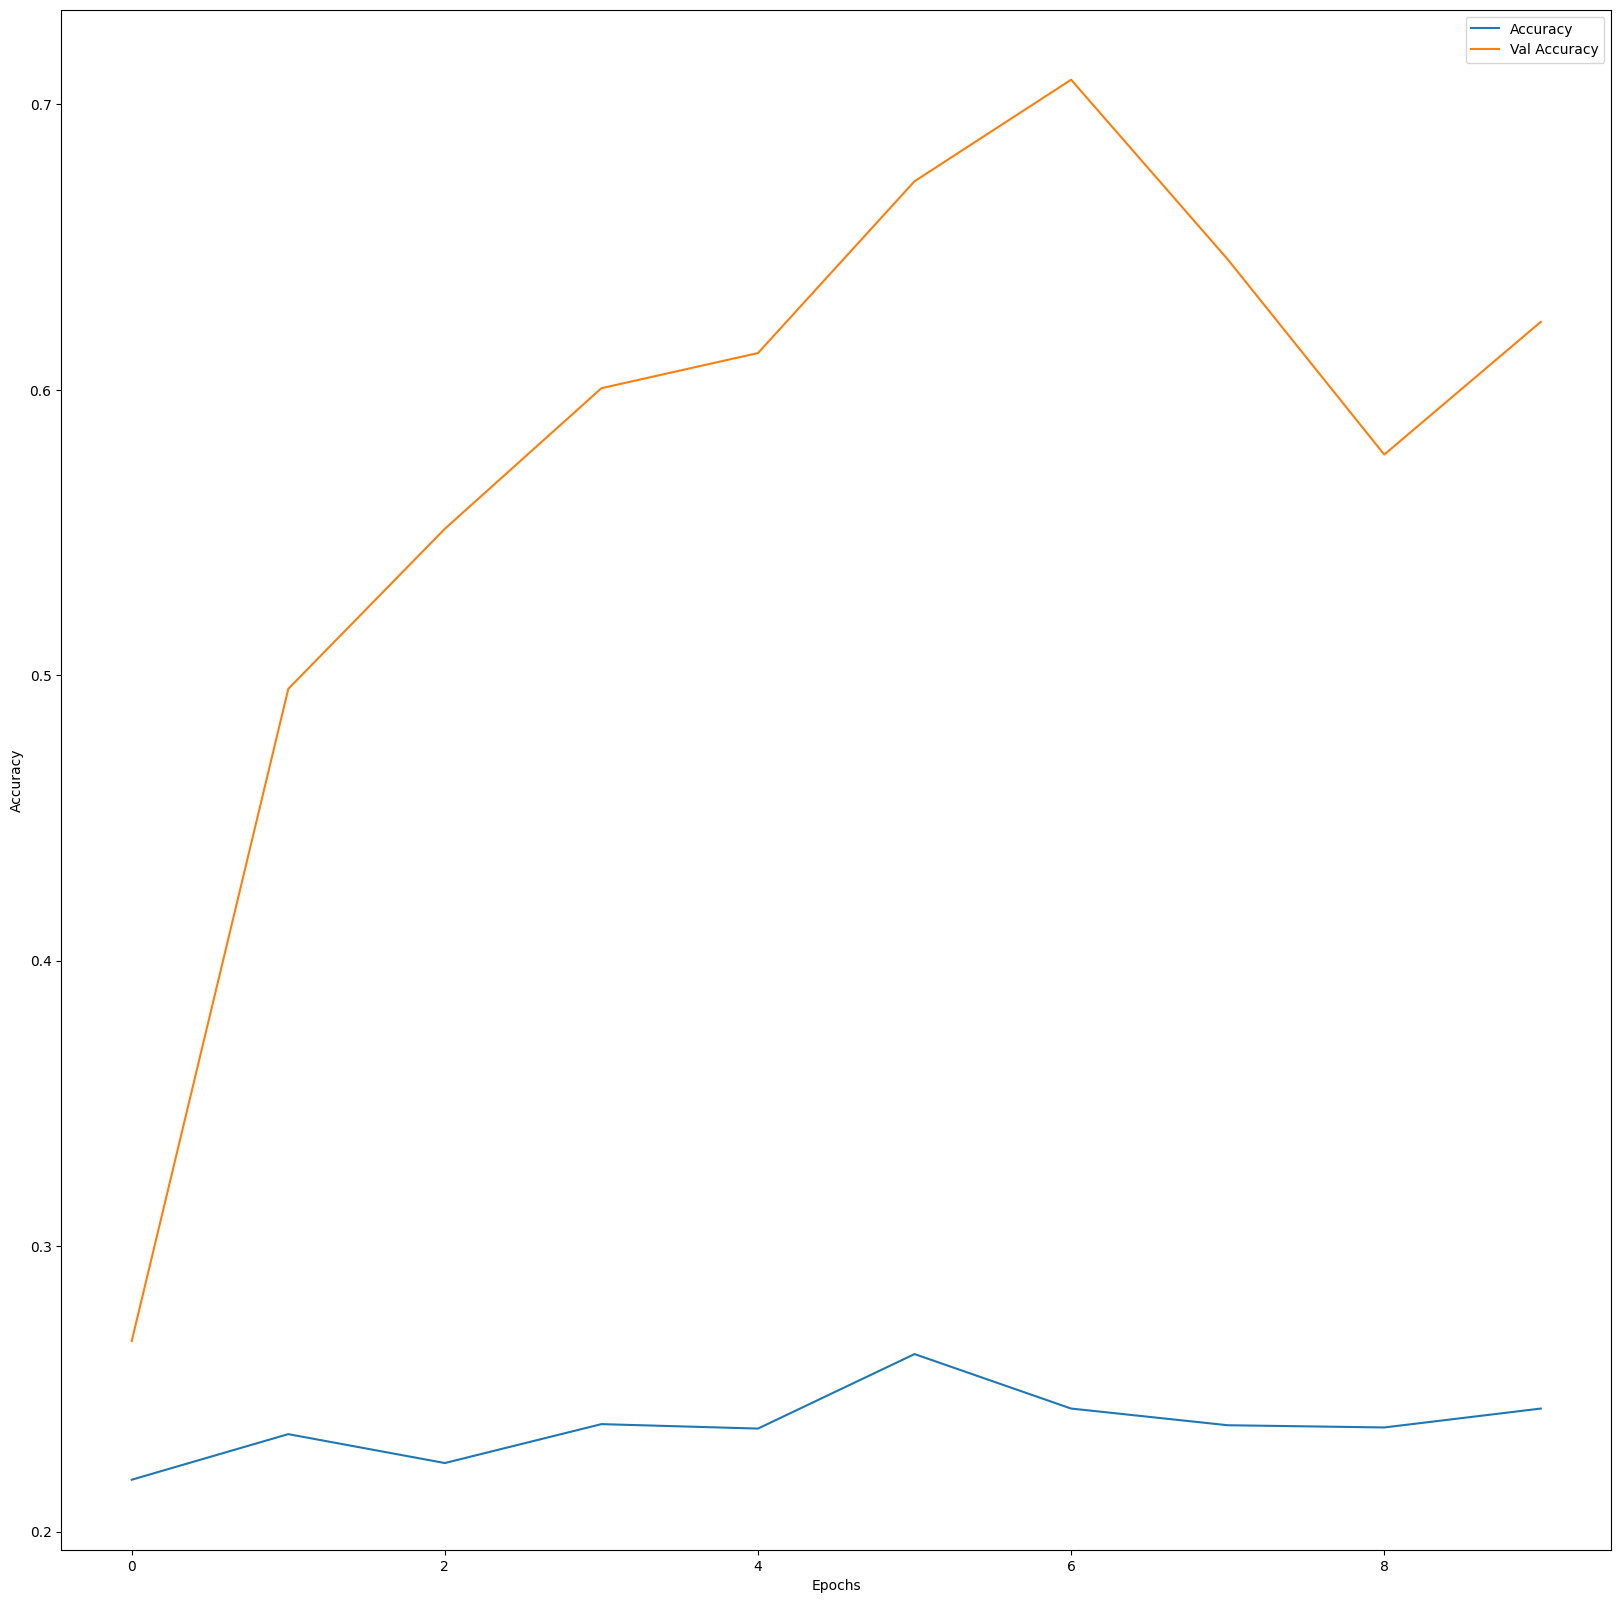

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

fig = plt.figure(figsize=(20 ,20))
plt.plot(history.history['accuracy'] , label = 'Accuracy')
plt.plot(history.history['val_accuracy'] , label = 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



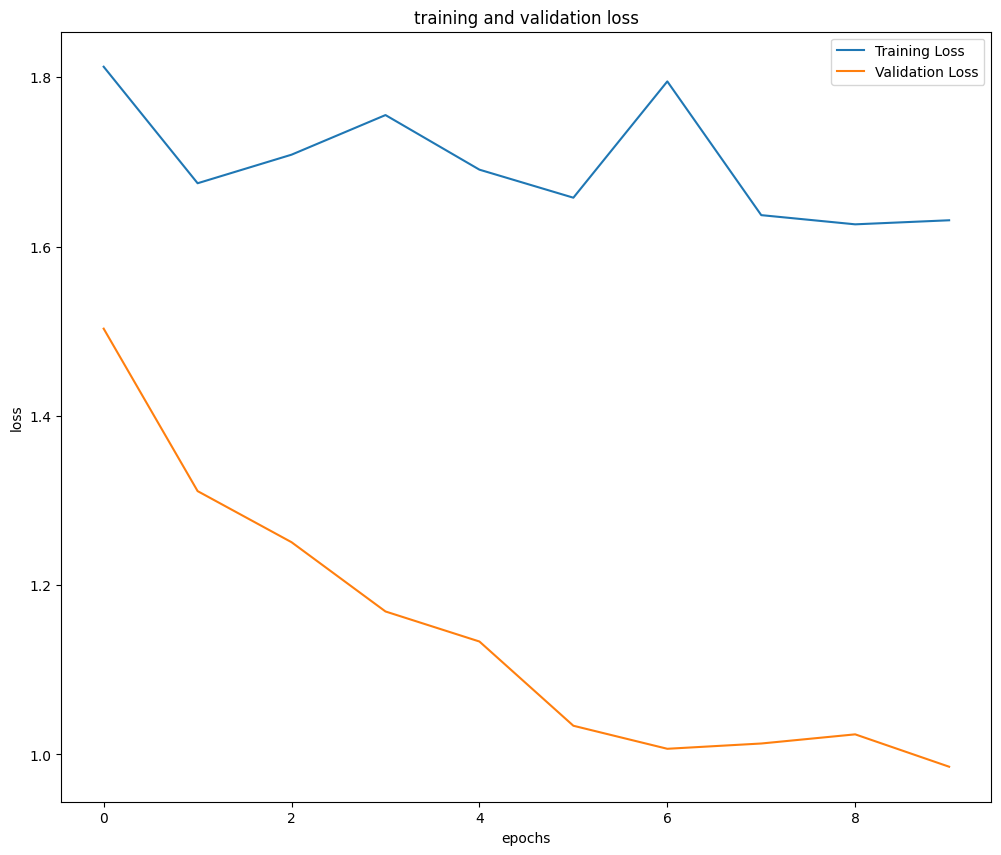

In [20]:
plt.figure(figsize=(12 , 10))
plt.plot(history.history['loss'] , label = 'Training Loss')
plt.plot(history.history['val_loss'] , label = 'Validation Loss')
plt.title("training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


In [21]:
import tensorflow as tf

print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: []
